# NYC Taxi homework2

### Data cleaning

#### First, we imported all the libraries we will use to answer the question

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from scipy import stats
import folium
import json
%matplotlib inline

#### before start the analysis we clean the data with the following code. For cleaning the data , we extract the year,month,hour from the  tpep_pickup_datetime and tpep_dropoff_datetime columns thereafter we create a new columns of mentioned extracted values.The year which were not 2018 are dropped, the months which were not belong to corresponding month are allocated in error dataframe.

In [ ]:

error=pd.DataFrame()
for i in range(1,7):
    d=pd.read_csv("yellow_tripdata_2018-0"+str(i)+".csv")
    d['yearS'] = pd.to_datetime(d["tpep_pickup_datetime"],format='%Y-%m-%d %H:%M:%S').dt.year
    d['yearE'] = pd.to_datetime(d["tpep_dropoff_datetime"],format='%Y-%m-%d %H:%M:%S').dt.year
    d['hourS'] = pd.to_datetime(d["tpep_pickup_datetime"],format='%Y-%m-%d %H:%M:%S').dt.hour
    d['weekdayS'] = pd.to_datetime(d["tpep_pickup_datetime"],format='%Y-%m-%d %H:%M:%S').dt.weekday
    d['monthS'] = pd.to_datetime(d["tpep_pickup_datetime"],format='%Y-%m-%d %H:%M:%S').dt.month
    d['hourE'] = pd.to_datetime(d["tpep_dropoff_datetime"],format='%Y-%m-%d %H:%M:%S').dt.hour
    d['weekdayE'] = pd.to_datetime(d["tpep_dropoff_datetime"],format='%Y-%m-%d %H:%M:%S').dt.weekday
    d['monthE'] = pd.to_datetime(d["tpep_dropoff_datetime"],format='%Y-%m-%d %H:%M:%S').dt.month    
    d=d.loc[(d.yearS==2018)&(d.yearE==2018)&(d.monthS<7)&(d.monthE<7)&(d.trip_distance>0.2)]
    error = error.append(d[d['monthS']!=i])
    d.reset_index(drop=True)
    d.to_csv("C:/Users/Daniele/Desktop/DATA cleaning/Filtered"+str(i)+".csv")
    del d

#### In the following script the months in the error dataframe are concatenated to their corresponding dataframe.

In [ ]:
for i in range(1,7):
    string_new = "C:/Users/Daniele/Desktop/DATA cleaning/Filtered"+str(i)+".csv"
    df = pd.read_csv(string_new)
    new = error.loc[error.monthS==i]
    df = pd.concat([df,new])
    df.reset_index(drop=True)
    df.to_csv("C:/Users/Daniele/Desktop/DATA cleaning1/Filtered"+str(i)+".csv")
    del df
    del new

## RQ1 In what period of the year Taxis are used more?
#### Create a plot that, for each month, shows the average number of trips recorded each day. Due to the differences among New York zones, we want to visualize the same information for each boroughs. Do you notice any difference among them? Provide comments and plausible explanations about what you observe (e.g.: what is the month with the highest daily average?)

##### We started the work by importing all the datasets for each month with Pandas, summed the number of daily trips for each month dividing by the number of days of the month , obtaining the desired average. After this operation we plot the result with seaborn. The first Graph show the average trips per Day for each month.

[Text(0,0.5,'Average Trips per Day'), Text(0.5,0,'Month')]

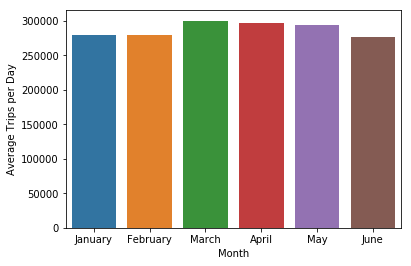

In [3]:
#list of months
months = 'January February March April May June'.split()
#create a new DataFrame
df_new = pd.Series(index = months)
for i in range(6):
    string = "Filtered"+str(i+1)+".csv"
    #read csv and take only tpep_pickup_datetime with usecols
    df = pd.read_csv(string,usecols=["tpep_pickup_datetime"])
    #using datetime in order to convert argument to datetime.
    df['day'] = pd.to_datetime(df["tpep_pickup_datetime"],format='%Y-%m-%d %H:%M:%S').dt.day
    #delete missing value
    df.dropna(inplace=True)
    #computation of average daily trip for every month
    df_new[months[i]] = len(df['day'])/(len(df['day'].unique()))
    #free memory
    del df
ax = sns.barplot(x=df_new.index, y=df_new.values)
ax.set(xlabel='Month', ylabel='Average Trips per Day')

#### Considering the graph, March is the month with the highest trip but the difference between the months is  not significant.

#### after this, we plot the same graph for every Borough. 

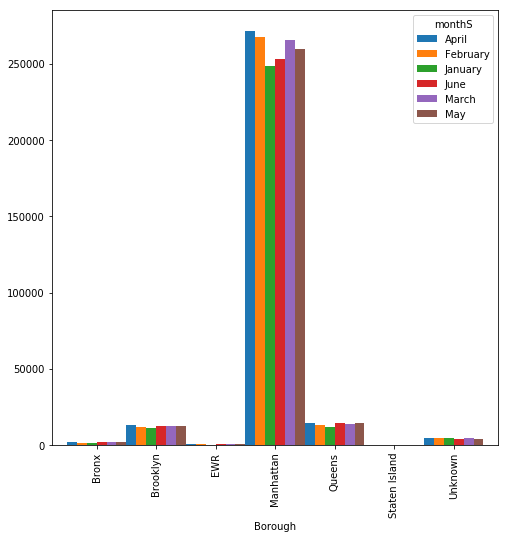

In [6]:
#create a list
dataframe=[]
#read csv file of zone
zones = pd.read_csv("taxi_zone_lookup.csv")
for i in range(1,7):
    #read csv file of taxi and take only tpep_pickup_datetime,monthS and DOLocationID with usecols
    df = pd.read_csv("Filtered"+str(i)+".csv",usecols=["tpep_pickup_datetime","monthS","DOLocationID"])
    #select the specific month
    df=df.loc[df.monthS==i]
    #merge Data Frame of taxi with DataFrame of zone and take only Borough,tpep_pickup_datetime and monthS column
    df = pd.merge(df,zones[['LocationID','Borough']], left_on=['DOLocationID'], right_on=['LocationID'])[['Borough',"tpep_pickup_datetime","monthS"]]
    #using datetime in order to convert argument to datetime
    df['day'] = pd.to_datetime(df["tpep_pickup_datetime"],format='%Y-%m-%d %H:%M:%S').dt.day
    #computation of daily trip average for every month in every Borough, 
    df2 =(df.groupby(['monthS','Borough']).count()['day']//len((df["day"].unique()))
    dataframe.append(df2)
d=pd.concat(dataframe)
#rename of index, with inplace=True the data is renamed in place
d.rename(index={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June'},inplace=True)
  """We have a multi index series(the output of groupby), ustack function on level 0 convert the 0 level of index as a columns 
         and the level -1 as an index"""
d.unstack(level=0).plot.bar(width=1.0, figsize=(8, 8))

####  The result shows tht Manhattan is the Borough wih the highest average daily trip in all the months examined; we expected that because Manhattam is the most commercial and turistic borough in comparision to others.

# RQ2 What are the time slots with more passengers?
#### Set your own time slots and discover which are those when Taxis drive the highest number of passengers overall New York and repeat the analysis for each borough. Provide the results through a visualization and comment them

#### We have choose to divide the day in 4 time slots in order to discover the time slot with highest passengers. We have created a list with 4 time slots,initialized a new data frame, read the data and take only our desired columns(dropna function is used to remove the missing values).Finally we have created a new column called df_total['time_slots'] in order to assign each hour in his related time slot; to do the lambda function is applied.

In [27]:
#set the time slots
time_slots = ['1.[1-6 AM]','2.[7-12 AM]','3.[13-18 PM]','4.[19-00 PM]']
#creation of new Dataframe
df_total = pd.DataFrame([])
for i in range(1,7):
    string = "Filtered"+str(i)+".csv"
    #import the dataset with required columns
    df = pd.read_csv(string,usecols=['hourS','DOLocationID','passenger_count'])
    #delete the missing value
    df.dropna(inplace=True)
    #add to the new Dataframe
    df_total = df_total.append(df,ignore_index=True)
    #free memory
    del df
#merge dt_total with zone.csv and take only required colums
df_total = pd.merge(df_total,zones[['LocationID','Borough']], left_on=['DOLocationID'], right_on=['LocationID'])[['Borough','hourS','passenger_count']]
df_total['time_slots'] = df_total.hourS.apply(lambda x:time_slots[abs((x-1)//6)])

#### Below, we plot the highest number of passengers for every time slots overall Newyork

Text(0.5,1,'Overall New York')

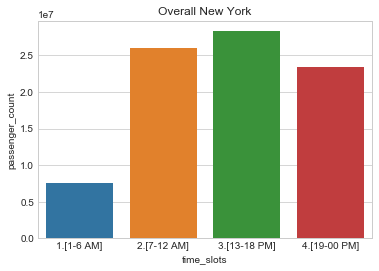

In [23]:
#gropby and sum are used in order to have the total number of passengers for every time slot
df_total=df_total.groupby('time_slots',as_index=False).sum()
#sort the value
df_total.sort_values(by='time_slots',inplace=True)
#plot
sns.set_style("whitegrid")
fig = sns.barplot(x=df_total.time_slots,y=df_total.passenger_count)
fig.set_title('Overall New York')

#### The plot shows us that there are more passenger from 3rd timeslot, which correspond to the start of evening. We think we have this result because our third time slot corresponds to the end of the working day, so more people used the taxi.

#### Now , in order to show the situation for every Borough we used subplot to have all plots in one figure. We have taken every single borough, used groupby on time_slot and sum the number of passengers in each time slot; finally draw the plots.

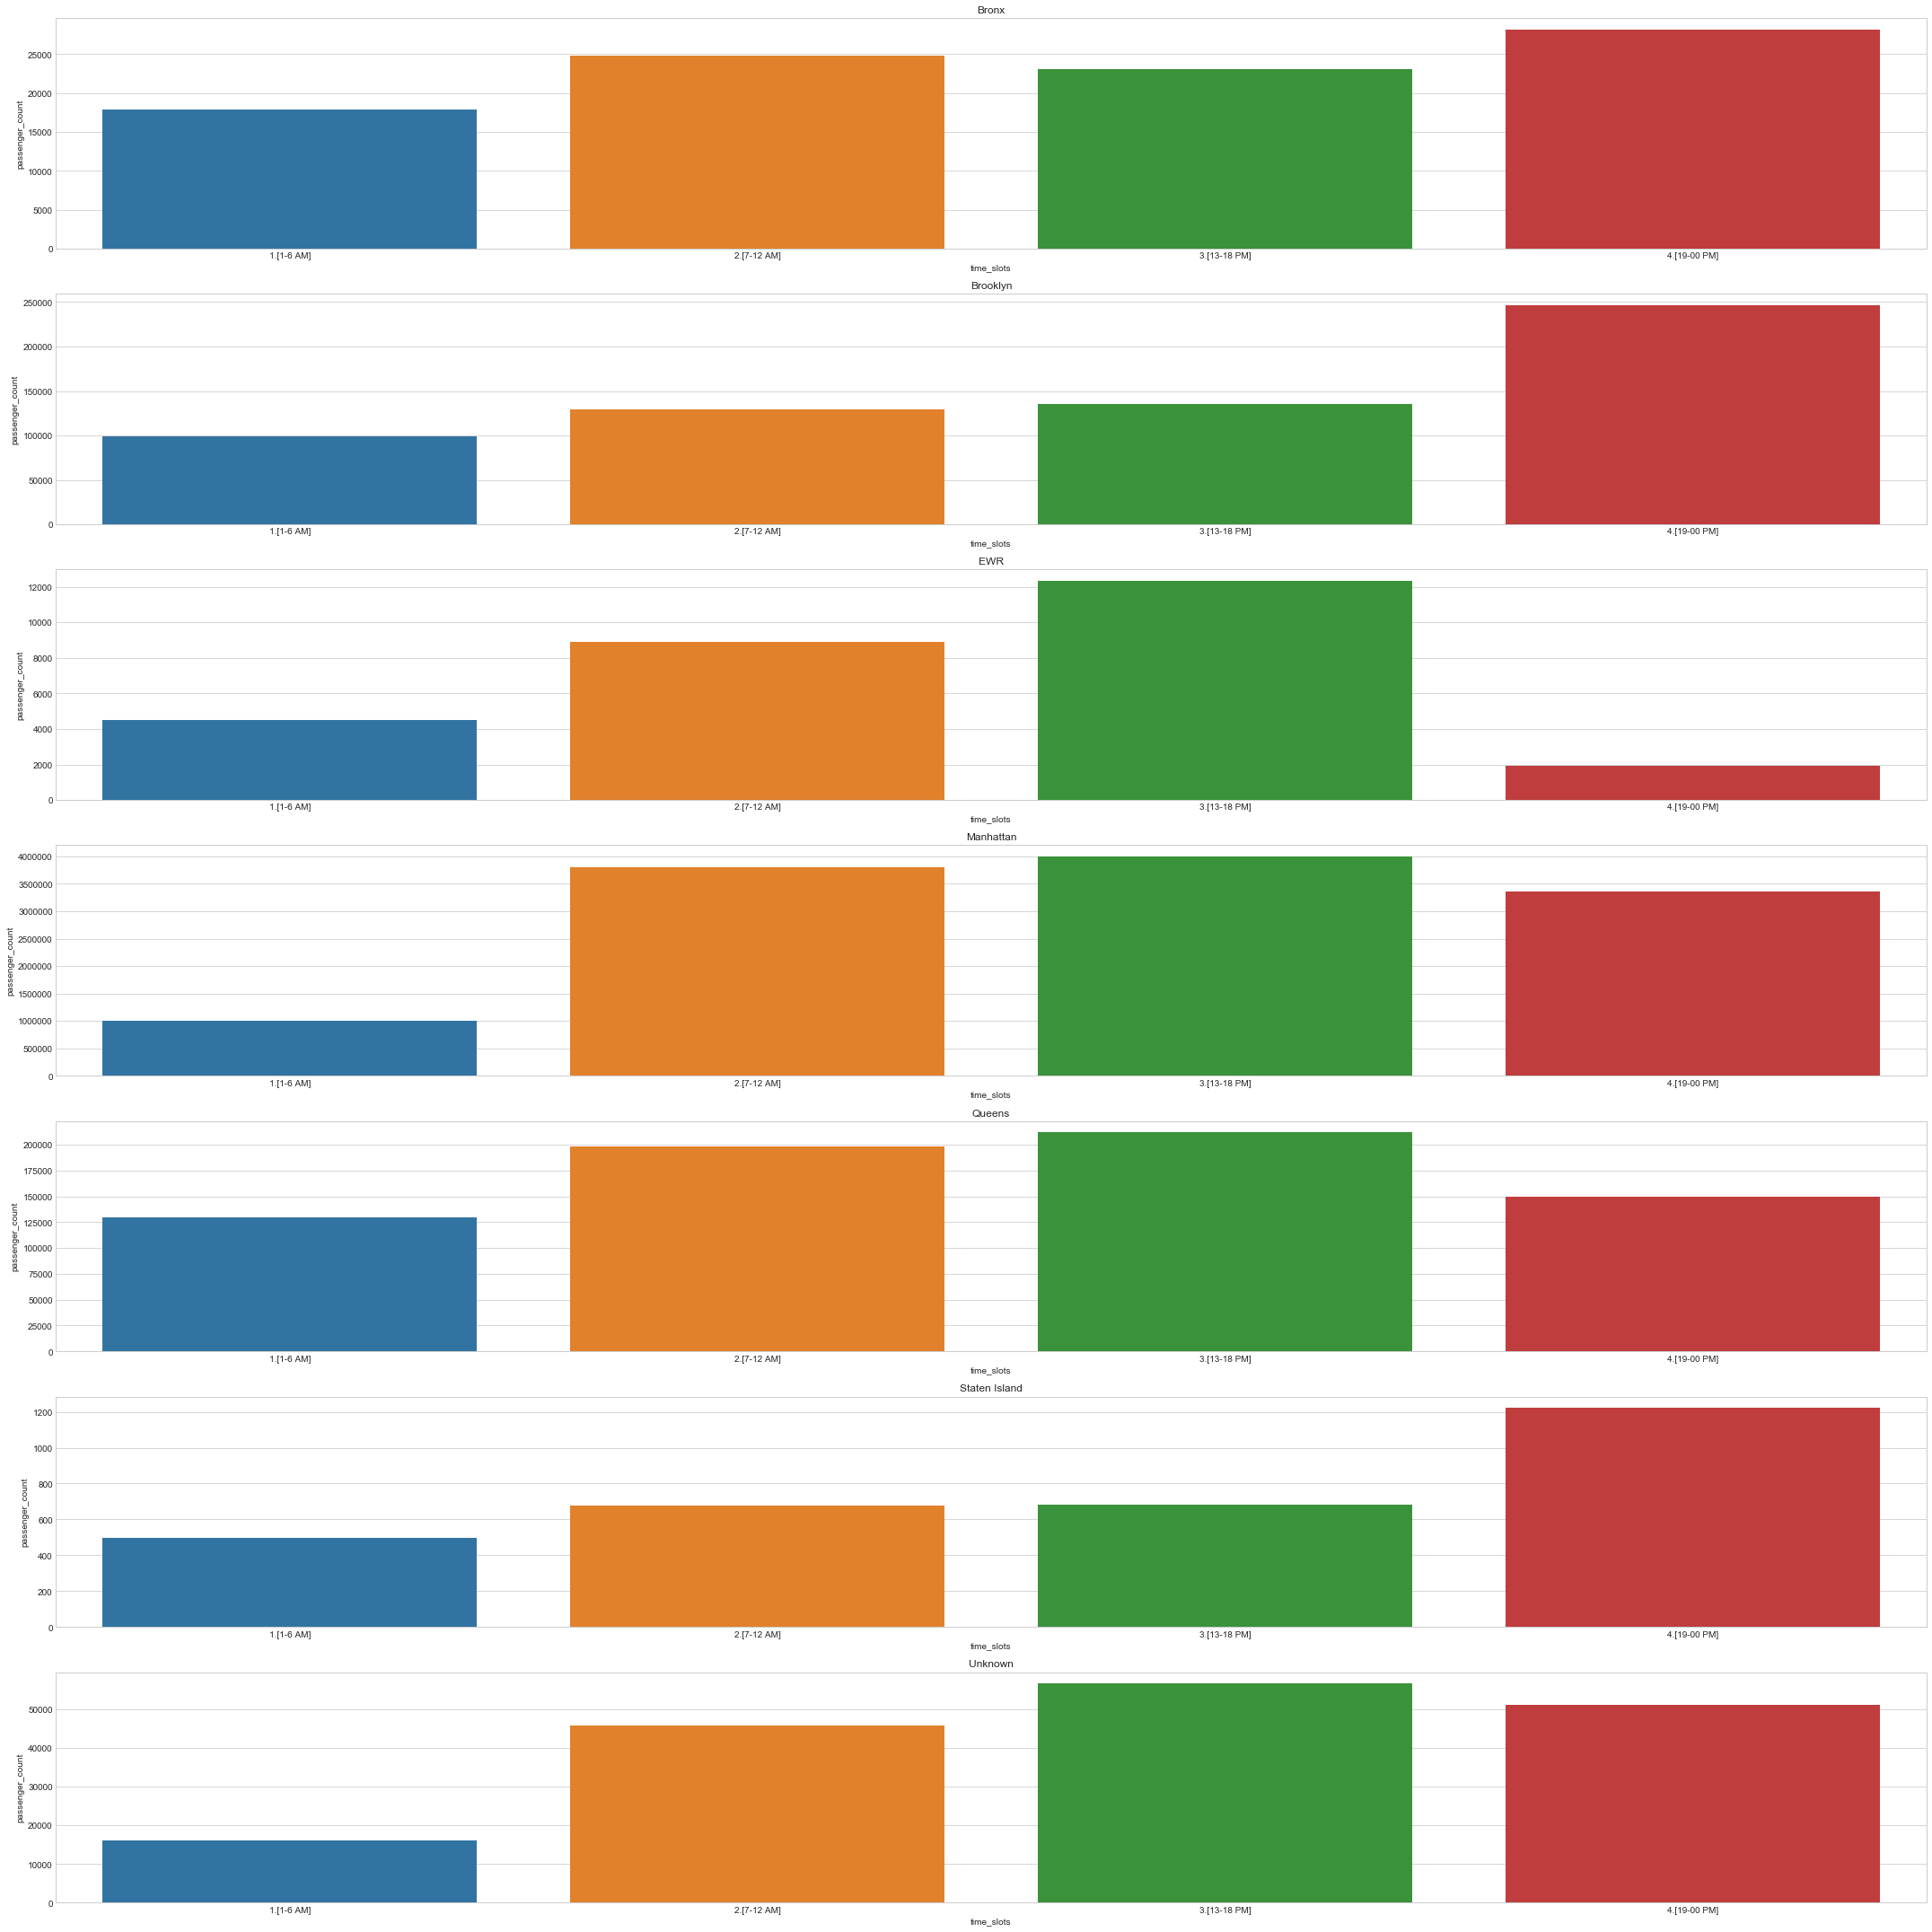

In [13]:
num_plots = 7
fig, axes = plt.subplots(num_plots,1,figsize=(30,30))
#a list of boroughs is created
Boroughs = df_total.Borough.unique()
#sorting boroughs
Boroughs.sort()
for Borough in Boroughs:
    #chose the data frame with corresponding borough
    df = df_total[df_total['Borough']==Borough]
    #use groupby and .sum() in order to take the of passengers in each time slot
    df=df.groupby('time_slots',as_index=False).sum()
    #sort values
    df.sort_values(by='time_slots',inplace=True)
    #set the axes for the current subplot
    ax_curr = axes[np.where(Boroughs == Borough)[0][0]]
    sns.set_style("whitegrid")
    fg = sns.barplot(x=df.time_slots,y=df.passenger_count,ax=ax_curr)
    ax_curr.set_title(Borough)
    del df
fig.tight_layout()

#### Regarding the plot there are slightly difference between number of passenger for each borough in specific time slot and the overall newyork situation

# RQ3 Do the all trips last the same? 
#### Let's put our attention on the distribution of trip's duration. Provide a plot for it and comment what you see. Run this analysis for NYC and for each borough (and obviously comment the results!).

#### The goal of this question is to investigate how our trip duration is distributed. In the first phase the duration is calculated based on tpep_pickup_datetime and tpep_dropoff_datetime; in order to do this, to_datetime() function is used.

In [2]:
df=[]
for i in range(1,7):
    #import the dataset
    d = pd.read_csv("Filtered"+str(i)+".csv",usecols=['tpep_pickup_datetime','tpep_dropoff_datetime','PULocationID','DOLocationID'])
    #create column called start_time where to_datetime is used to convert argument in tpep_pickup_datetime to datetime format
    d['start-time'] = pd.to_datetime(d['tpep_pickup_datetime'])
    #create column called End_time where to_datetime is used to convert argument in tpep_dropoff_datetime to datetime format
    d['End-time'] = pd.to_datetime(d['tpep_dropoff_datetime'])
    #compute difference between tpep_dropoff_datetime and tpep_pickup_datetime
    d["duration"]=d["End-time"]-d["start-time"]
    #convert the duration to minute and we assign into new coloum
    d["durationm"]=d["duration"]/pd.Timedelta('1 minute')
    d["durations"]=d["duration"]/pd.Timedelta('1 second')
    d['years'] = pd.to_datetime(d["tpep_pickup_datetime"],format='%Y-%m-%d %H:%M:%S').dt.year
    d['yeare'] = pd.to_datetime(d["tpep_dropoff_datetime"],format='%Y-%m-%d %H:%M:%S').dt.year
    #append to list df in order to concatenate in next sesssion
    df.append(d)
    del d   

#### for each dataframe in df (which is a list) we filter duration and unknown zone. The duration is filtered because we found out that the duration less than 5000 seconds follow the chi-square distribution. 

In [3]:
dft=[]
for d in df:
    #PULocationID which are corresponded to unknown zones are filtered
    dft.append(d.loc[(d.durations>20)&(d.durations<5000)&(d.PULocationID!=264)&(d.PULocationID!=265)])
del df    

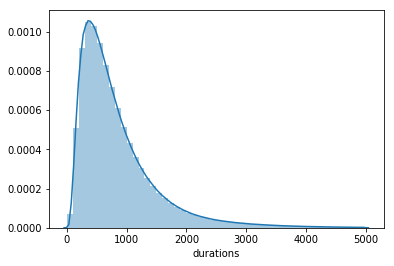

In [4]:
#concatenate the list of datasets in dft list into DF dataframe
#DF=pd.concat(dft)
dft=dft.reset_index(drop=True)
DF=dft
del dft
sns.distplot(DF["durations"])  

In [5]:
zone=pd.read_csv("taxi_zone_lookup.csv")
dfz=zone[['LocationID','Borough']]    

for d in dft:
    d.rename(columns={'PULocationID':'LocationID'},inplace=True)
dj=[]
for d in dft:
    #each dataframe in dft list is joined with the zone dataset 
    dj.append(dfz.join(d.set_index('LocationID'), on='LocationID'))    
del dft    
dj1=[]
for d in dj:
    #for each dataframe in dj the index is reset and the previous index is dropped
    d=d.reset_index(drop=True)
    dj1.append(d[["Borough","LocationID","durations"]])
del dj
dj1=pd.concat(dj1)
dj1=dj1.reset_index(drop=True)
#take the unique values of borough and convert it to list
subset=dj1["Borough"].unique().tolist()
#the range is fom 0 to 6 because last one (7) is unknown
subset=subset[0:6]  

Text(0,0.5,'Density')

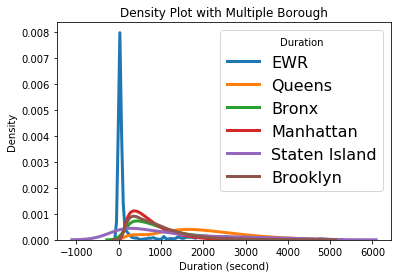

In [6]:
#in subset we have all boroughs 
for s in subset:
    l = dj1[dj1['Borough'] == s]
    l=l.dropna()
    # Draw the density plot
    sns.distplot(l['durations'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = s)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Duration')
plt.title('Density Plot with Multiple Borough')
plt.xlabel('Duration (second)')
plt.ylabel('Density')

# RQ4 What is the most common way of payments? 
#### Discover the way payments are executed in each borough and visualize the number of payments for any possible means. Then run the Chi-squared test to see whether the method of payment is correlated to the borough. Then, comment the results.

#### In order to answer to this question, initially we plotted the most used payment method for each Borough using the same methodology applied in the previous points

Text(0.5,1,'payment type for every Borough')

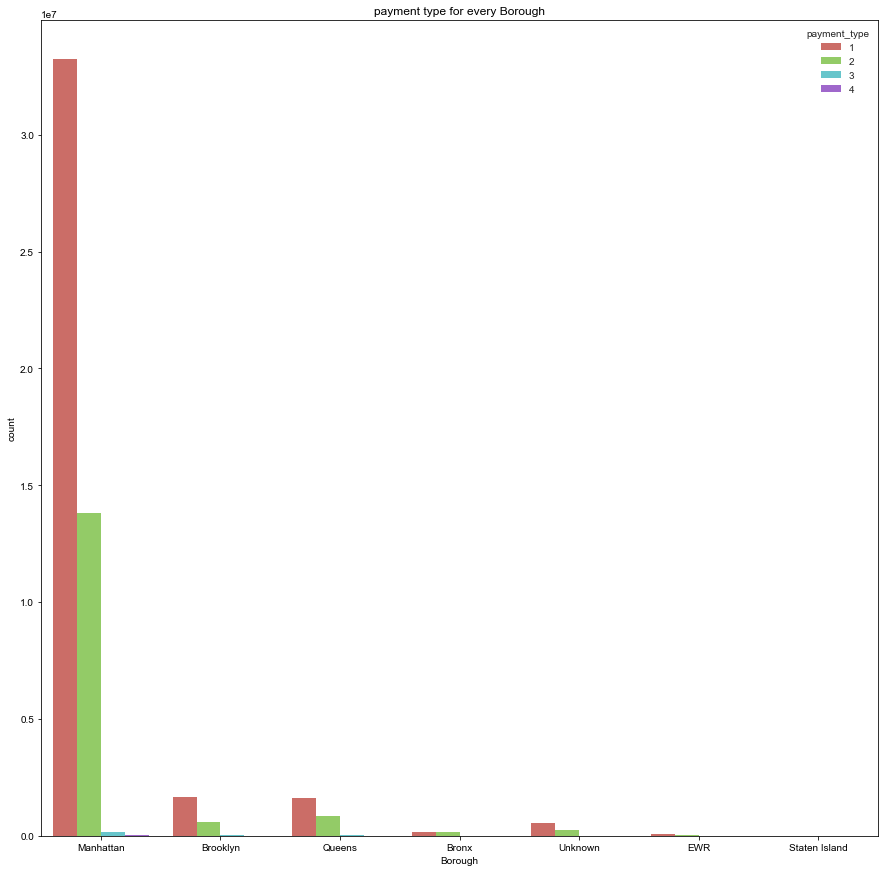

In [4]:
zones = pd.read_csv("taxi_zone_lookup.csv")
#list of month
months = 'January February March April May June'.split()
#creation of a DataFrame
df_total = pd.DataFrame([])
#plot specifications
fig, axes = plt.subplots(1,1,figsize=(15,15))
for i in range(1,7):
    string = "Filtered"+str(i)+".csv"
    #import dataset
    df = pd.read_csv(string)
    #select the columns useful for carrying out the analysis 
    df = df[["DOLocationID","payment_type","monthS"]]
    #merge df with the zone.csv and take only Borough,payment_type and month
    df = pd.merge(df,zones[['LocationID','Borough']], left_on=['DOLocationID'], right_on=['LocationID'])[['Borough','payment_type','monthS']]
    #add to the  df_total dataframe
    df_total = df_total.append(df,ignore_index=True)
    #free memory
    del df
#created a new column called df_total['month'] in order to assign the name to each month; to do this the lambda function is applied
df_total['month'] = df_total['monthS'].apply(lambda x : months[x-1])
sns.set_style("whitegrid")
fg = sns.countplot(x='Borough', hue='payment_type', data=df_total,palette='hls')
fg.set_title('payment type for every Borough')

#### The plot show us that the most common way of payment is credit card(payment type 1) ,this situation is the same in every borough. Another thing that shows us the graph is that the type of payment most used is the one most commonly used in Manhattan, maybe because Manhattan is the commercial zone of Newyork.

#### After seeing that the type of payment most used is the credit card and that this type of payment is numerically greater in Manhattan, let's see if method of payment is correlated to the borough with Chi squared test. First we take all the payment type for every Borough

In [5]:
manhattan_value = df_total.loc[df_total['Borough'] == 'Manhattan']['payment_type']
Bronx_value = df_total.loc[df_total['Borough'] == 'Bronx']['payment_type']
Brooklyn_value = df_total.loc[df_total['Borough'] == 'Brooklyn']['payment_type']
EWR_value = df_total.loc[df_total['Borough'] == 'EWR']['payment_type']
Queens_value = df_total.loc[df_total['Borough'] == 'Queens']['payment_type']
State_Island_value = df_total.loc[df_total['Borough'] == 'Staten Island']['payment_type']

#### After this we use value_counts() to take a count of the number of payments for each type for every Borought, we add them to an array and then we created a DataFrame from array

In [7]:
chi_test=np.array([manhattan_value.value_counts().sort_index(axis=0),Bronx_value.value_counts().sort_index(axis=0),Brooklyn_value.value_counts().sort_index(axis=0),EWR_value.value_counts().sort_index(axis=0),Queens_value.value_counts().sort_index(axis=0),State_Island_value.value_counts().sort_index(axis=0)]).T
chi_test_2=pd.DataFrame(chi_test)
chi_test_2

,0,1,2,3,4,5
0,33227442,161935,1659526,76238,1601156,7237
1,13797530,165783,583785,18782,845321,3573
2,170505,4272,13555,674,21172,126
3,49880,1429,4124,174,5761,37


#### We are interested in knowing if there is a correlation between Borough and payment type, in order to do this we have used the Chi squared test. Before start we need to state our null hypothesis $H0$: 'There is no statistically significant relationship between Borough and payment type'. To determine if we accept ore reject the null hypothesis we need to compute P-value. We use library scipy to complete this task.

In [21]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(chi_test_2)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
189106.93237467718


===Degrees of Freedom===
15


===P-Value===
0.0


===Contingency Table===
[[3.32885465e+07 2.36328148e+05 1.58992168e+06 6.95248498e+04
  1.79870403e+06 7.84383278e+03]
 [1.41363309e+07 1.00359230e+05 6.75176941e+05 2.95244576e+04
  7.63838555e+05 3.33096597e+03]
 [2.47426450e+05 1.75657519e+03 1.18175385e+04 5.16762929e+02
  1.33693717e+04 5.83014853e+01]
 [6.74772412e+04 4.79046794e+02 3.22283609e+03 1.40929706e+02
  3.64604642e+03 1.58997689e+01]]


#### The results from Chi square test show us that P-value is equal to 0,so we can reject the null hypothesys, the column are not independent and we have a great correlation between borough and payment type.

# RQ5 Does a long distance correlate with the duration of the trip on average?
#### Make a plot that show the dependence between distance and duration of the trip. Then compute the Pearson Coefficient, is it significant? Comment the results you obtain.

#### We have choose to filtered the distance; after using .describe() on dataset in order to see the mean of  trip distance, we have choosen to remove all distance minors of 2.

In [2]:
c = pd.DataFrame([])
for month in range(6):
    string = "yellow_tripdata_2018-0"+str(month+1)+"_new.csv"
    df = pd.read_csv(string,usecols=['tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance'])
    #take long distances
    df = df[df['trip_distance']>2]  
    df.dropna(inplace=True)
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    #compute the duration of the trips
    df['trip_duration'] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"])
    #convert the durtion to minute
    df['trip_duration'] = pd.to_timedelta(df['trip_duration']).apply(lambda x:x.seconds/60)
    #append to df_total DataFrame
    df_total = df_total.append(df[['trip_distance','trip_duration']],ignore_index=True)
    del df

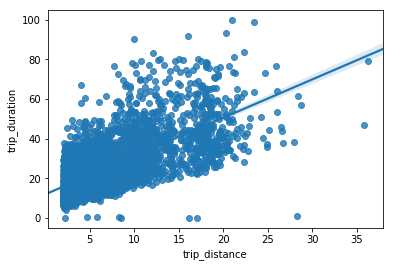

In [5]:
#filtered strange values on max trip duration and max trip distance
df1 = df_total[(df_total['trip_duration'] <= 100) & (df_total['trip_distance'] <= 40)]
#plot data and a linear regression model fit
ax = sns.regplot(x="trip_distance", y="trip_duration", data=df1.sample(5000))

#### Now we compute the pearson coefficient which describe the linear correlation between two variables; it has a value between +1 and -1. A value of 1 implies that a linear equation describe the correlation between 2 variable perfectly where Y increase as X increase, a value of 0 implies that there is no linear correlation between the variables and -1 describe a situation where Y decrease and X increase.

In [6]:
#compute pearson coefficient
correlation = df1.corr(method='pearson')
print(correlation)

               trip_distance  trip_duration
trip_distance       1.000000       0.721409
trip_duration       0.721409       1.000000


#### The result show us that we have and high values of pearson coefficient, so we have a great correlation between long distance a duration of trip.

# CRQ1: Does the fare for mile change across NY's borough? 
## #We want to discover whether the expenses of a user that enjoys Taxis in one zone is different from those that uses it in another one.
#### 1)Considering the fare amount:
#### -Compute the price per mile equation for each trip.
#### -Run the mean and the standard deviation of the new variable for each borough. Then plot the distribution. What do you see?
#### -Run the t-test among all the possible pairs of distribution of different boroughs.
#### -Can you say that statistically significant differences, on the averages, hold among zones? In other words, are Taxis trip in some boroughs, on average, more expensive than others?
#### 2)The price per mile might depend on traffic the Taxi finds on its way. So we try to mitigate this effect:
#### -Likely, the duration of the trip says something about the city's congestion, especially if combined with the distances. It might be a good idea to weight the price for mile using the T time equation needed to complete the trip. Thus, instead of P equation, you can useP'=P/T equation, where T equation is the time needed to complete the trip.
#### -Run the mean and the standard deviation of the new variable for each borough. Then plot the distribution. What do you see?
#### -Run the t-test among all the possible pairs of new distribution of different boroughs.
#### -Can you say that statistically significant differences, on the averages, hold among zones? In other words, are Taxis trip in some boroughs, on average, more expensive than others?
#### -3)Compare the results obtained for the price per mile and the weighted price for mile. What do you think about that?

#### In the following script for each dataset the duration of trip based on pickup and dropoff time calculated. the price per mile and the price per mile over the duration is calculated for each dataset.

In [2]:
dft=[]
for i in range(1,7):
    df=pd.read_csv("C:/Users/Atefeh/Desktop/ADM2/Filtered"+str(i)+".csv",usecols=['fare_amount','trip_distance','tpep_dropoff_datetime','tpep_pickup_datetime','PULocationID','total_amount'])
    df["Pricem"]=df["fare_amount"]/df["trip_distance"]
    df['start-time'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['End-time'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df["durationm"]=(df["End-time"]-df["start-time"])/pd.Timedelta('1 minute')
    df["durations"]=(df["End-time"]-df["start-time"])/pd.Timedelta('1 second')
    df["Pricem/m"]=df["Pricem"]/df["durationm"]
    # the trips with less than 20 seconds and less than 0.1 mile distance are filtered.
    # the unknown zones are also filtered
    df=df.loc[(df.durations>20) & (df.fare_amount>0) & (df.trip_distance>0.1) & (df.total_amount>0.8) & (df.PULocationID!=264) & (df.PULocationID!=265)]
    df=df.reset_index(drop=True)
    dft.append(df[["Pricem","PULocationID","Pricem/m"]])
    del df

In [5]:
#dft contains the list of dataframes with the required columns. in the following script we concat the dataframes.
dft=pd.concat(dft)
dft=dft.reset_index(drop=True)
d=dft.loc[dft.Pricem<10]

#### After we visulize the  distribution plot for overall Newyorkof the price per mile , we noticed that the price per mile from 0 to 10 is  following  the chi_squre distribution in other words most of the data is distributed in this range. we also found out that for some trips the price is too much high which is no reasonable, therefore we filtered them, at the end we plot the price per mile for in 0 to 10 range.

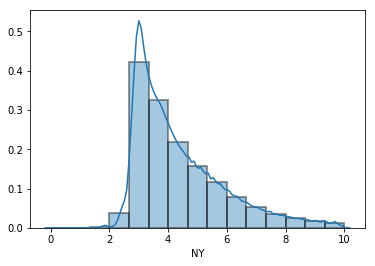

In [6]:
sns.distplot(d['Pricem'],kde=True,bins=15,hist_kws=dict(edgecolor="k", linewidth=2),axlabel="NY")

#### Below, we plot the distribution of price per mile for each Borough.

In [7]:
#The zone dataset is joined with d(which is the dataset of overall Newyork)
zone=pd.read_csv("taxi_zone_lookup.csv")
dfz=zone[['LocationID','Borough']]
d.rename(columns={'PULocationID':'LocationID'},inplace=True)
dfz=dfz.join(d.set_index('LocationID'), on='LocationID')
dfz=dfz.reset_index(drop=True)

C:\Users\Daniele\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [8]:
#we find the unique values of Borough, then we choose the first 6 values of the list because the last one in Unknown
Boroughs = (dfz["Borough"].unique().tolist())[0:6]
dm=pd.DataFrame(columns=['mean','std'],index=Boroughs)

#### In the following Script  the distribution is drawn for each borough.  Then we calulated the mean and standard deviation. 

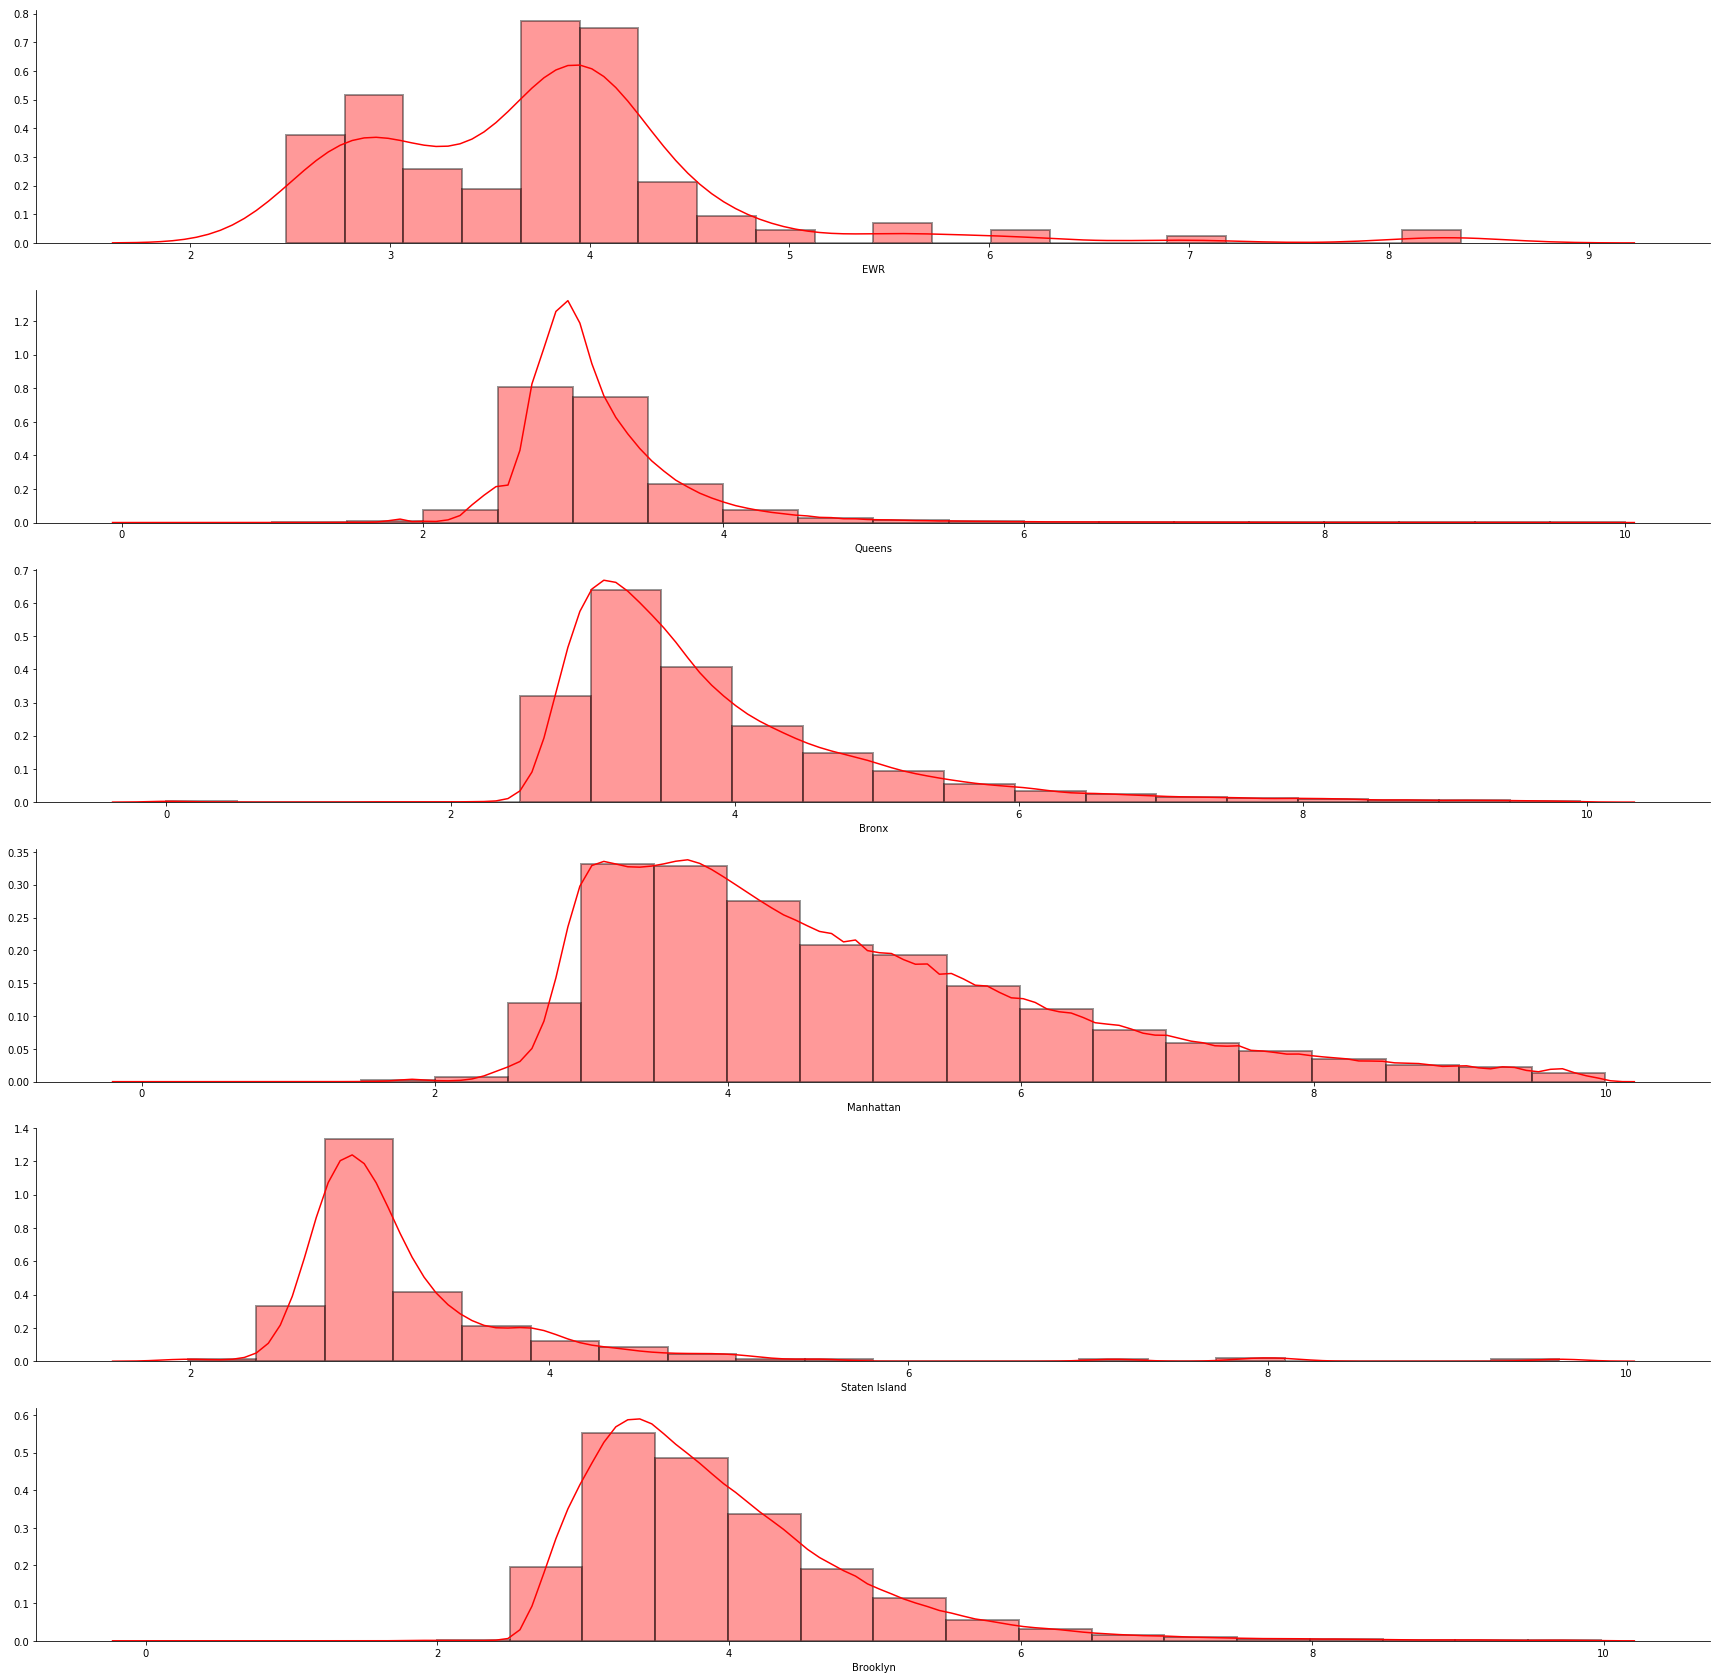

In [9]:
import matplotlib.pyplot as plt
i=0
Boroughs = (dfz["Borough"].unique().tolist())[0:6]
fig, axes = plt.subplots(6,1,figsize=(30,30))
for l in Boroughs:
    a=dfz.loc[dfz.Borough==l]
    a=a.dropna()
    m=a["Pricem"].mean()
    s=a["Pricem"].std()
    dm.loc[l,"mean"]=m
    dm.loc[l,"std"]=s
    #ax_curr = axes[np.where(Boroughs == l)[0][0]]
    sns.distplot(a['Pricem'],kde=True,bins=20,color='red',hist_kws=dict(edgecolor="k", linewidth=2),ax=axes[i],axlabel=l)
    #sns.distplot(a['Pricem'],kde=True,bins=15,hist_kws=dict(edgecolor="k", linewidth=2,alpha=0.5),ax=ax_curr,label='Overall New York')
    #axes.legend()
    sns.despine()
    i+=1
#print(dm)

#### The mean and Standard Deviation for each plot shows that the price per mile for each region . As we expected the mean for Manhattan is the highest

In [10]:
dm

,mean,std
EWR,3.76785,0.922644
Queens,3.17083,0.584818
Bronx,3.85587,1.11117
Manhattan,4.74907,1.54532
Staten Island,3.25741,0.844929
Brooklyn,3.93745,0.931696


#### Below we calculate the t-test for each pair of borough in order to determine whether the means of two samples are significantliy different.  As the Paired Student’s t-test is useful while the variance of two samples are equle , we used the Welch’s t-test which can be implemented with ttest_ind() function , just the equal_va parameter should be assigned False. In this regard we have two hypothesis. which is Null hypothesis (H0): u1 = u2, which translates to the mean of sample 1 is equal to the mean of sample 2 Alternative hypothesis (HA): u1 ≠ u2, which translates to the mean of sample 1 is not equal to the mean of sample 2, Therefore, If the p-value is less than what is tested at, most commonly 0.05, one can reject the null hypothesis.

In [11]:
from scipy import stats
boroughs=dfz["Borough"].unique().tolist()[0:6]
Boroughs1=boroughs
# Create a MultiIndex DataFrame in order to store the result of p-value and t-value and the hypothesis 
idx = pd.MultiIndex.from_product([boroughs,
                                  ['t-value', 'p-value', 'H0 hypothesis']])
col = boroughs
dt = pd.DataFrame('-', idx, col)
# Create two for loops in order to calculate the t-test for each pair of boroughs
for i in boroughs:
    a=dfz.loc[dfz.Borough==i]["Pricem"]
    a=a.dropna()
    for j in Boroughs1:
            b=dfz.loc[dfz.Borough==j]["Pricem"]
            b=b.dropna()
            t2, p2 = stats.ttest_ind(a,b,equal_var = False)
            dt.loc[(i,"t-value"),j]=t2
            dt.loc[(i,"p-value"),j]=p2
            if(p2>0.05):
                dt.loc[(i,"H0 hypothesis"),j]='Fail to Reject H0'
            else:
                dt.loc[(i,"H0 hypothesis"),j]='Reject H0'

In [12]:
dt

EWR             Queens  \
EWR           t-value                        0            12.2919   
              p-value                        1        1.00344e-34   
              H0 hypothesis  Fail to Reject H0          Reject H0   
Queens        t-value                 -12.2919                  0   
              p-value              1.00344e-34                  1   
              H0 hypothesis          Reject H0  Fail to Reject H0   
Bronx         t-value                 0.951135            152.643   
              p-value                 0.341549                  0   
              H0 hypothesis  Fail to Reject H0          Reject H0   
Manhattan     t-value                  7.64592             1565.6   
              p-value              2.07483e-14                  0   
              H0 hypothesis          Reject H0          Reject H0   
Staten Island t-value                 -5.53675            2.28364   
              p-value              5.74875e-08          0.0223929   
              H0 hypothesis          Reject H0          Reject H0   
Brooklyn      t-value                  2.19104            497.624   
              p-value                0.0284505                  0   
              H0 hypothesis          Reject H0          Reject H0   

                                         Bronx          Manhattan  \
EWR           t-value                -0.951135           -7.64592   
              p-value                 0.341549        2.07483e-14   
              H0 hypothesis  Fail to Reject H0          Reject H0   
Queens        t-value                 -152.643            -1565.6   
              p-value                        0                  0   
              H0 hypothesis          Reject H0          Reject H0   
Bronx         t-value                        0            -76.235   
              p-value                        1                  0   
              H0 hypothesis  Fail to Reject H0          Reject H0   
Manhattan     t-value                   76.235                  0   
              p-value                        0                  1   
              H0 hypothesis          Reject H0  Fail to Reject H0   
Staten Island t-value                 -8.27619           -14.8915   
              p-value               1.3616e-16        3.74917e-50   
              H0 hypothesis          Reject H0          Reject H0   
Brooklyn      t-value                  10.7926           -215.286   
              p-value              3.80221e-27                  0   
              H0 hypothesis          Reject H0          Reject H0   

                                 Staten Island           Brooklyn  
EWR           t-value                  5.53675           -2.19104  
              p-value              5.74875e-08          0.0284505  
              H0 hypothesis          Reject H0          Reject H0  
Queens        t-value                 -2.28364           -497.624  
              p-value                0.0223929                  0  
              H0 hypothesis          Reject H0          Reject H0  
Bronx         t-value                  8.27619           -10.7926  
              p-value               1.3616e-16        3.80221e-27  
              H0 hypothesis          Reject H0          Reject H0  
Manhattan     t-value                  14.8915            215.286  
              p-value              3.74917e-50                  0  
              H0 hypothesis          Reject H0          Reject H0  
Staten Island t-value                        0           -11.2538  
              p-value                        1        2.27309e-29  
              H0 hypothesis  Fail to Reject H0          Reject H0  
Brooklyn      t-value                  11.2538                  0  
              p-value              2.27309e-29                  1  
              H0 hypothesis          Reject H0  Fail to Reject H0

#### Below we did the same for Price per mile over duration, we consider duration as seconds and minutes. The plot for minutes were more meaningful, Therefore we choose minutes.

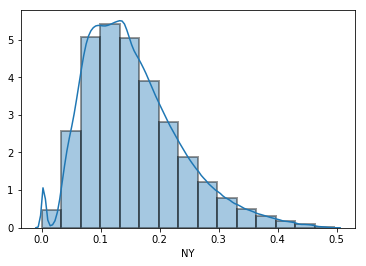

In [13]:
sns.distplot(d['Pricem/m'],kde=True,bins=15,hist_kws=dict(edgecolor="k", linewidth=2),axlabel="NY")

#### The distribution plot for new variable Pricem/m( which is price per mile over duration) is drawn below.

In [14]:
Boroughs = (dfz["Borough"].unique().tolist())[0:6]
dn=pd.DataFrame(columns=['mean','std'],index=Boroughs)

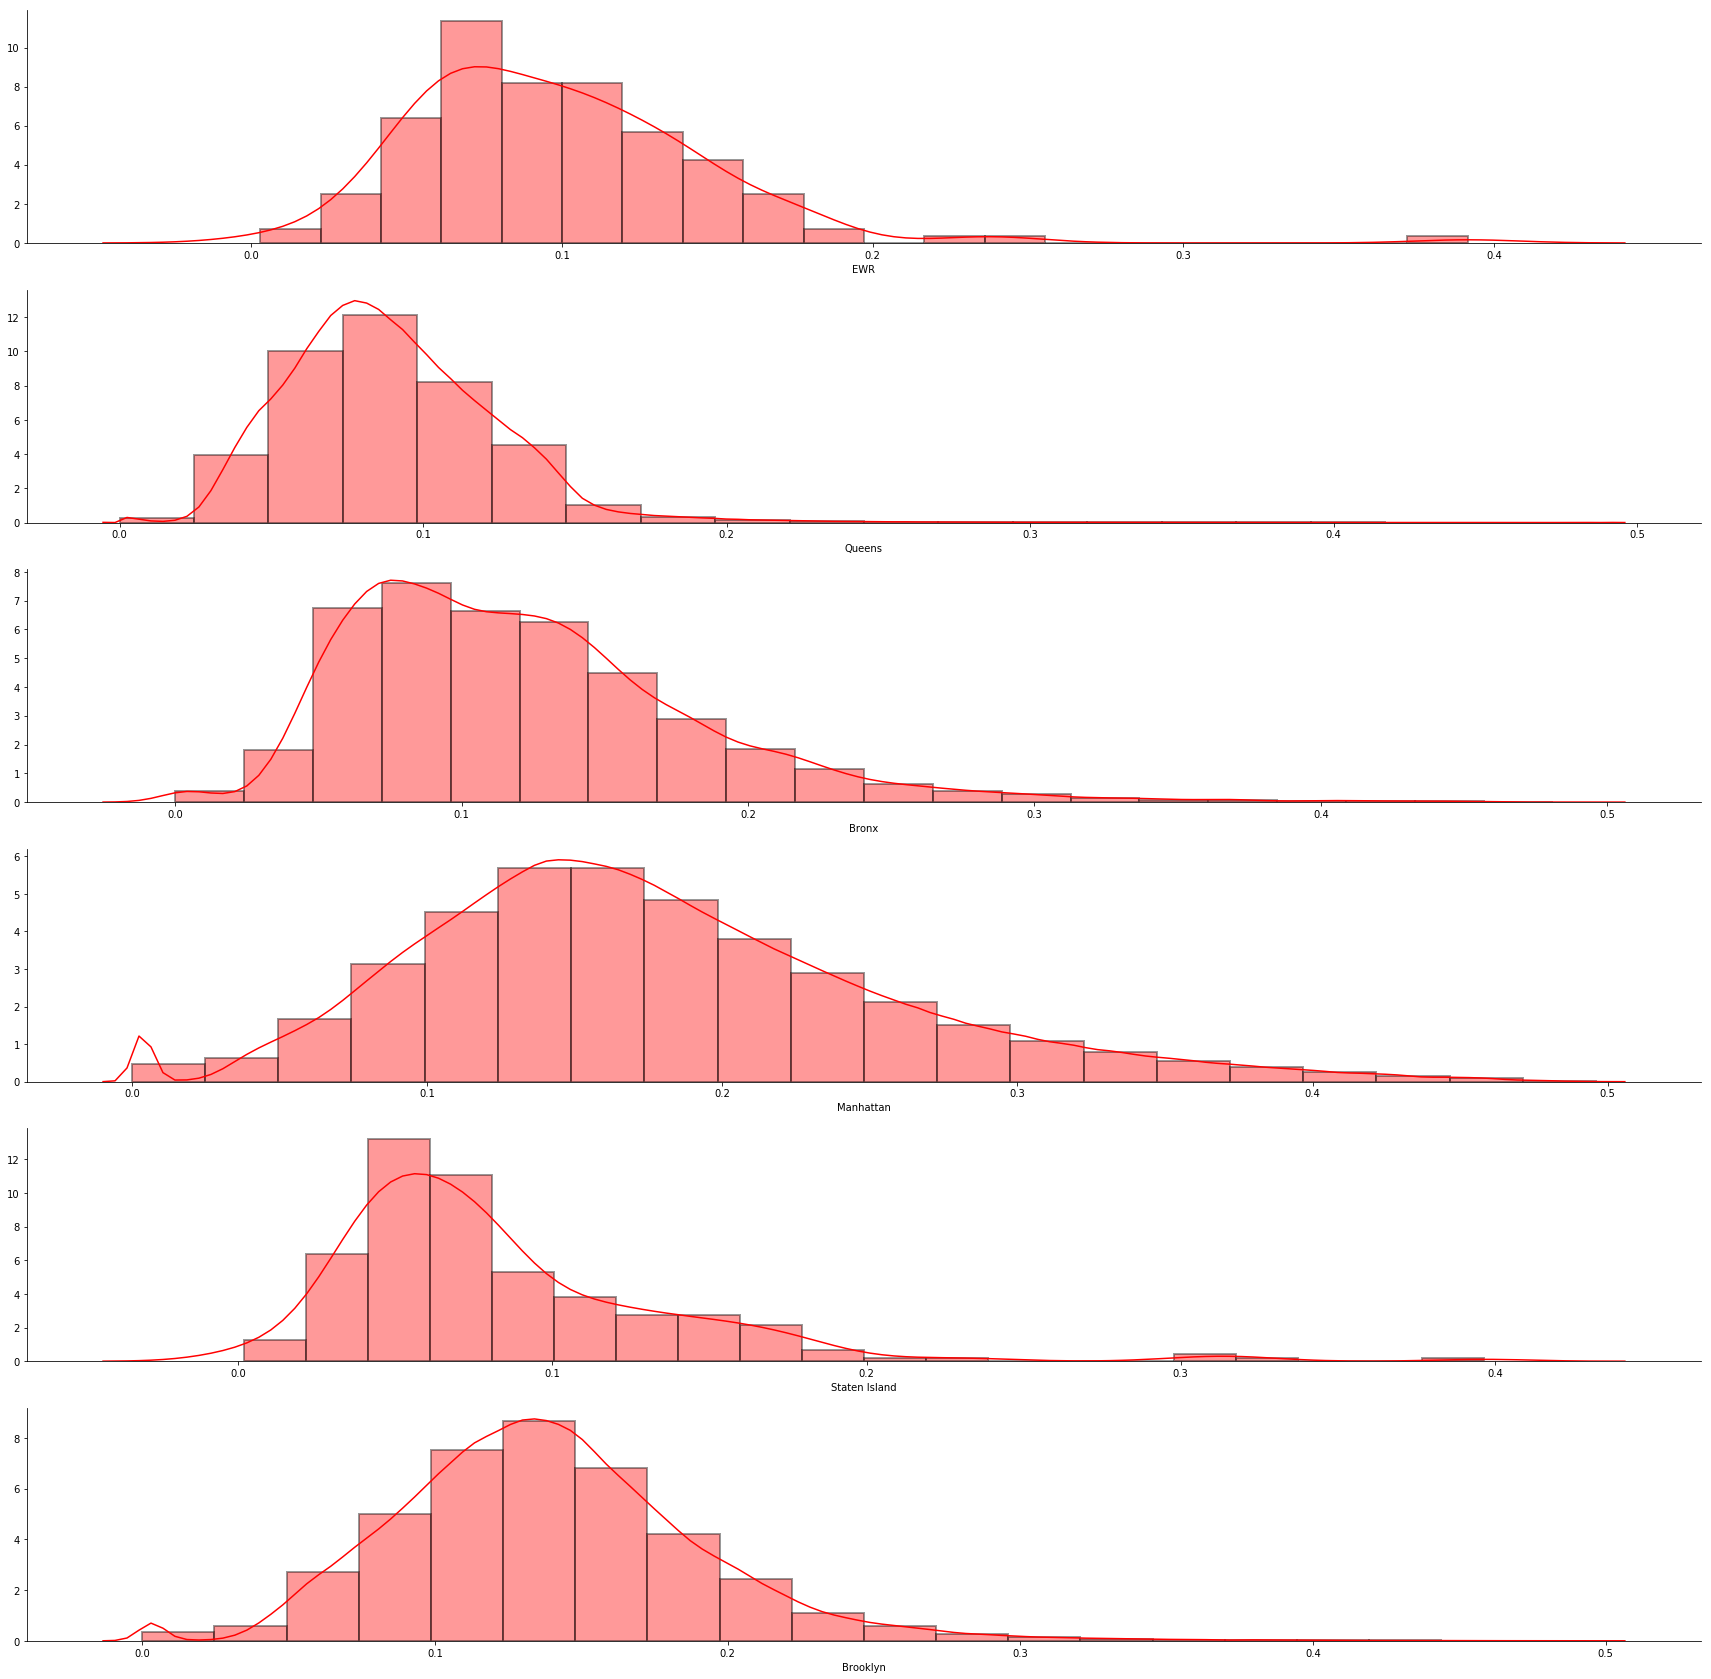

In [15]:
import matplotlib.pyplot as plt
i=0
Boroughs = (dfz["Borough"].unique().tolist())[0:6]
fig, axes = plt.subplots(6,1,figsize=(30,30))
for l in Boroughs:
    a=dfz.loc[dfz.Borough==l]
    a=a.dropna()
    m=a["Pricem/m"].mean()
    s=a["Pricem/m"].std()
    dn.loc[l,"mean"]=m
    dn.loc[l,"std"]=s
    sns.distplot(a['Pricem/m'],kde=True,bins=20,color='red',hist_kws=dict(edgecolor="k", linewidth=2),ax=axes[i],axlabel=l)
    sns.despine()
    i+=1

In [16]:
#Same as before the MultiIndex dataframe is created 
idx = pd.MultiIndex.from_product([boroughs,
                                  ['t-value', 'p-value', 'H0 hypothesis']])
col = boroughs
dtt = pd.DataFrame('-', idx, col)
for i in boroughs:
    print(i)
    a=dfz.loc[dfz.Borough==i]["Pricem/m"]
    a=a.dropna()
    for j in Boroughs1:
            b=dfz.loc[dfz.Borough==j]["Pricem/m"]
            b=b.dropna()
            t2, p2 = stats.ttest_ind(a,b,equal_var = False)
            dtt.loc[(i,"t-value"),j]=t2
            dtt.loc[(i,"p-value"),j]=p2
            if(p2>0.05):
                dtt.loc[(i,"H0 hypothesis"),j]='Fail to Reject H0'
            else:
                dtt.loc[(i,"H0 hypothesis"),j]='Reject H0'

EWR
Queens
Bronx
Manhattan
Staten Island
Brooklyn


In [17]:
dtt

EWR             Queens  \
EWR           t-value                        0             3.3549   
              p-value                        1        0.000793944   
              H0 hypothesis  Fail to Reject H0          Reject H0   
Queens        t-value                  -3.3549                  0   
              p-value              0.000793944                  1   
              H0 hypothesis          Reject H0  Fail to Reject H0   
Bronx         t-value                  4.49436            121.965   
              p-value              7.02256e-06                  0   
              H0 hypothesis          Reject H0          Reject H0   
Manhattan     t-value                  11.8551            1683.09   
              p-value              2.02523e-32                  0   
              H0 hypothesis          Reject H0          Reject H0   
Staten Island t-value                 -2.77221           -2.49177   
              p-value               0.00584106          0.0127108   
              H0 hypothesis          Reject H0          Reject H0   
Brooklyn      t-value                  9.26931            550.161   
              p-value              1.89446e-20                  0   
              H0 hypothesis          Reject H0          Reject H0   

                                         Bronx          Manhattan  \
EWR           t-value                 -4.49436           -11.8551   
              p-value              7.02256e-06        2.02523e-32   
              H0 hypothesis          Reject H0          Reject H0   
Queens        t-value                 -121.965           -1683.09   
              p-value                        0                  0   
              H0 hypothesis          Reject H0          Reject H0   
Bronx         t-value                        0           -92.3959   
              p-value                        1                  0   
              H0 hypothesis  Fail to Reject H0          Reject H0   
Manhattan     t-value                  92.3959                  0   
              p-value                        0                  1   
              H0 hypothesis          Reject H0  Fail to Reject H0   
Staten Island t-value                 -9.59721           -18.1294   
              p-value              9.28236e-22        1.87397e-73   
              H0 hypothesis          Reject H0          Reject H0   
Brooklyn      t-value                  41.3541           -197.664   
              p-value                        0                  0   
              H0 hypothesis          Reject H0          Reject H0   

                                 Staten Island           Brooklyn  
EWR           t-value                  2.77221           -9.26931  
              p-value               0.00584106        1.89446e-20  
              H0 hypothesis          Reject H0          Reject H0  
Queens        t-value                  2.49177           -550.161  
              p-value                0.0127108                  0  
              H0 hypothesis          Reject H0          Reject H0  
Bronx         t-value                  9.59721           -41.3541  
              p-value              9.28236e-22                  0  
              H0 hypothesis          Reject H0          Reject H0  
Manhattan     t-value                  18.1294            197.664  
              p-value              1.87397e-73                  0  
              H0 hypothesis          Reject H0          Reject H0  
Staten Island t-value                        0           -16.3792  
              p-value                        1         2.9952e-60  
              H0 hypothesis  Fail to Reject H0          Reject H0  
Brooklyn      t-value                  16.3792                  0  
              p-value               2.9952e-60                  1  
              H0 hypothesis          Reject H0  Fail to Reject H0

# CRQ2: Visualize Taxis movements! 
#### NYC is divided in many Taxis zones. For each yellow cab trip we know the zone the Taxi pick up and drop off the users. Let's visualize, on a chropleth map, the number of trips that starts in each zone. Than, do another map to count the races that end up in the single zone. Comment your discoveries

#### In order to show the zone with most pick up and drop off we start to create again a new dataframe where we  put PULocationID and DOLocationID

In [3]:
zones = pd.read_csv("taxi_zone_lookup.csv")
value_to_choropleth = pd.DataFrame([])
for i in range(6):
    string = "Filtered"+str(i+1)+".csv"
    df = pd.read_csv(string,usecols=["PULocationID","DOLocationID"])
    df.dropna(inplace=True)
    value_to_choropleth=value_to_choropleth.append(df,ignore_index=True)
    del df

## Number of trips that starts in each zone

In [4]:
#merge the DataFrame value_to_choropleth with zone.csv
value_to_choropleth_start = pd.merge(value_to_choropleth,zones, left_on=['PULocationID'], right_on=['LocationID'])[['Zone','PULocationID']]
#used groupby and count in order to have a dataframe with zone and the count of trips started in every zone
test=value_to_choropleth_start.groupby(['Zone'],as_index=False).count()
test.columns=['Zone','Counter']
value_to_choropleth_start2 = pd.merge(test,zones, left_on=['Zone'], right_on=['Zone'])

In [5]:
#initialize the map
map_1 = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=12)

In [6]:
#loaad the json with the coordinate
with open('taxi_zones.json') as f:
    data = json.load(f)

In [11]:
# .choropleth function of folium is used to see the choropleth map
map_1.choropleth(
    geo_data='taxi_zones.json',
    data=value_to_choropleth_start2,
    columns=['LocationID','Counter'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    legend_name='Taxi Counter',
    fill_opacity=0.7,
    line_opacity=0.2,
    threshold_scale = [20,200,2000,20000,200000,2000000]
    
)
map_1.save('GeoJSON_New_york_Start.html')

In [1]:
from IPython.display import IFrame

IFrame(src='GeoJSON_New_york_Start.html', width=1200, height=600)

#### we have used the same approach for the zone where the taxi end the service

## Number of trips that end in each zone

In [13]:
value_to_choropleth_end = pd.merge(value_to_choropleth,zones, left_on=['DOLocationID'], right_on=['LocationID'])[['Zone','DOLocationID']]
test1=value_to_choropleth_end.groupby(['Zone'],as_index=False).count()
test1.columns=['Zone','Counter']
value_to_choropleth_end2 = pd.merge(test1,zones, left_on=['Zone'], right_on=['Zone'])

In [14]:
map_1.choropleth(
    geo_data='taxi_zones.json',
    data=value_to_choropleth_end2,
    columns=['LocationID','Counter'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    legend_name='Taxi Counter',
    fill_opacity=0.7,
    line_opacity=0.2,
    threshold_scale = [20,200,2000,20000,200000,2000000]
    
)
map_1.save('GeoJSON_New_york_end.html')

In [2]:
IFrame(src='GeoJSON_New_york_end.html', width=1200, height=600)